# CSE 555 Introduction to Pattern Recognition Spring 2020
# Problem Set 5 - Generative Models
## Srisai Karthik Neelamraju, 50316785 neelamra@buffalo.edu

## 3. Implementing VAE with CNN to generate MNIST images

### Importing the required libraries

NumPy is used for basic matrix operations.<br>
TensorFlow is used to implement the neural networks and import the MNIST dataset.<br>
Matplotlib is used for visualizing images generated by the VAE.<br>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as k
from matplotlib import pyplot as plt

### Loading the MNIST dataset

MNIST Dataset contains 28 $\times$ 28 dimensional grayscale images of handwritten digits from 0 to 9. Specifically, there are 60,000 images in the training set and 10,000 images in the test set. Each of these 70,000 images belongs to one of these 10 classes and has associated with it a label from 0 to 9.

In [2]:
# loading the dataset consisting of 60,000 training images
(X_train, _), (_, _) = mnist.load_data()

x_dim, y_dim = X_train[0].shape

# reshaping the input array to include channels
X_train = X_train.reshape(X_train.shape[0], x_dim, y_dim, 1)

# normalizing the data
X_train =  X_train / 255

### Creating a class for implementing a Convolutional Variational Autoencoder

In [3]:
class CVAE:
    """
        implements a convolutional variational autoencoder (CVAE)
    """

    def __init__(self, latent_dim=4, show_summary=False):
        """
            initializes a CVAE
        """
        self.latent_dim = latent_dim
        
        # defining the encoder architecture
        self.encoder = self.init_encoder()

        # defining the mean and standard deviation layers
        self.mean_vector = tf.keras.layers.Dense(self.latent_dim, name='mean_vector')(self.encoder.output)
        self.std_vector = tf.keras.layers.Dense(self.latent_dim, name='std_vector')(self.encoder.output)
        
        # sampling latent vector [3]
        def sampling(args):
            mean, std = args
            batch_size = k.shape(mean)[0]
            latent_dim = k.int_shape(std)[1]
            epsilon = k.random_normal(shape=(batch_size, latent_dim))
            return mean + k.exp(0.5 * std) * epsilon
        
        # adding the sampling layer to the encoder architecture
        self.sampled_vector = tf.keras.layers.Lambda(sampling, name='sampled_vector')([self.mean_vector, self.std_vector])
        self.encoder = tf.keras.Model(self.encoder.inputs, outputs=[self.mean_vector, self.std_vector, self.sampled_vector])

        # defining the decoder architecture
        self.decoder = self.init_decoder()

        # defining the combined VAE architecture
        self.vae = tf.keras.Model(self.encoder.inputs, self.decoder(self.encoder(self.encoder.inputs)[2]))

        # defining the VAE loss [3]
        def custom_loss():
            reconst_loss = tf.keras.losses.mse(k.flatten(self.vae.inputs), k.flatten(self.vae.output)) * x_dim * y_dim
            kl_div = - 0.5 * k.sum(1 + self.std_vector - k.square(self.mean_vector) - k.exp(self.std_vector), axis=-1)
            return k.mean(reconst_loss + kl_div)

        # compiling the VAE model
        self.vae.add_loss(custom_loss())
        self.vae.compile(optimizer=tf.keras.optimizers.Adam())

        if show_summary:
            print("Encoder Network")
            self.encoder.summary()
            print("Decoder Network")
            self.decoder.summary()
            print("VAE Combined Network")
            self.vae.summary()

    def init_encoder(self):
        """
            encoder neural network with convolutional layers
        """
        encoder = tf.keras.Sequential()
        encoder.add(tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', input_shape=(x_dim, y_dim, 1)))
        encoder.add(tf.keras.layers.MaxPooling2D(2, padding='valid'))
        encoder.add(tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'))
        encoder.add(tf.keras.layers.MaxPooling2D(2, padding='valid'))
        encoder.add(tf.keras.layers.Flatten())
        encoder.add(tf.keras.layers.Dense(10, activation='relu'))
        return encoder

    def init_decoder(self):
        """
            decoder neural network with deconvolutional layers
        """
        decoder = tf.keras.Sequential()
        decoder.add(tf.keras.layers.Dense(6272, activation='relu', input_shape=(self.latent_dim, )))
        decoder.add(tf.keras.layers.Reshape((7, 7, 128)))
        decoder.add(tf.keras.layers.UpSampling2D(2))
        decoder.add(tf.keras.layers.Conv2DTranspose(32, 3, activation='relu', padding='same'))
        decoder.add(tf.keras.layers.UpSampling2D(2))
        decoder.add(tf.keras.layers.Conv2DTranspose(16, 3, activation='relu', padding='same'))
        decoder.add(tf.keras.layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same'))
        return decoder
    
    def train(self, X_train, epochs=30, batch_size=32):
        """
            trains the CVAE on the MNIST training set
        """
        print("Training the VAE for " + str(epochs) + " epochs...")
        self.vae.fit(X_train, batch_size=batch_size, epochs=epochs, verbose=False)
        print("DONE")

    def generate_images(self, n=25):
        """
            generates images from the CVAE
        """
        print("Generating some images from the trained CVAE")
        fig = plt.figure(figsize=(7, 7))
        for i in range(n):
            sub = fig.add_subplot(5, 5, i + 1)
            sub.imshow(self.decoder.predict(np.random.normal(size=(1, self.latent_dim))).reshape(x_dim, y_dim), cmap='gray')
            plt.axis('off')

### Training a Convolutional Variational Autoencoder

In [4]:
cvae = CVAE()
cvae.train(X_train, epochs=30)

Instructions for updating:
Colocations handled automatically by placer.
Training the VAE for 30 epochs...
Instructions for updating:
Use tf.cast instead.
DONE


### Generating a few images using the trained CVAE

Generating some images from the trained CVAE


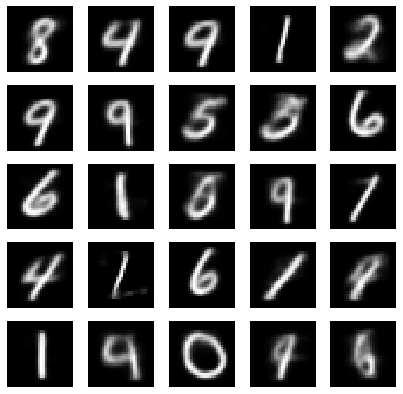

In [6]:
cvae.generate_images()

### References

1. Duda, Richard O., Peter E. Hart, and David G. Stork. Pattern Classification. John Wiley & Sons, 2012. <br>
2. CSE 555 Intoduction to Pattern Recognition Lecture Slides by Prof. Wen Dong <br>
3. https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder_deconv.py <br>
4. http://yann.lecun.com/exdb/mnist/